In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendarUSFH
import calendar
import seaborn as sns


%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
trips = pd.read_csv('data/trip.csv',low_memory=False)

In [3]:
def splitDateAndTime(dateAndTime):
    splitLine = dateAndTime.split(' ')
    return str(splitDate(splitLine[0]))  + splitTime(splitLine[1])

def splitDate(date):
    lineSplit = date.split('/')
    return str(lineSplit[2]) + str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1] if int(lineSplit[1]) >= 10 else '0' + str(lineSplit[1]) )

def splitTime(time):
    lineSplit = time.split(':')
    return str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1])

    

Unicamente vamos a tener en cuenta el dia en el cual se realizo el viaje

In [5]:
trips['start_date'] = trips['start_date'].apply(lambda x : pd.to_datetime(splitDate(x.split(' ')[0])) )

In [6]:
trips['end_date'] = trips['end_date'].apply(lambda x : pd.to_datetime(splitDate(x.split(' ')[0])) )

In [7]:
trips['numberdayofweek'] = trips['start_date'].apply(lambda x : x.dayofweek)
trips['dayofweek'] = trips['start_date'].apply(lambda x : calendar.day_name[x.dayofweek])

In [8]:
trips.sample()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,numberdayofweek,dayofweek
29083,43171,787,2013-10-02,Powell at Post (Union Square),71,2013-10-02,San Francisco City Hall,58,541,Subscriber,94403,2,Wednesday


### ¿Como es la distribucion de los viajes durante el año?

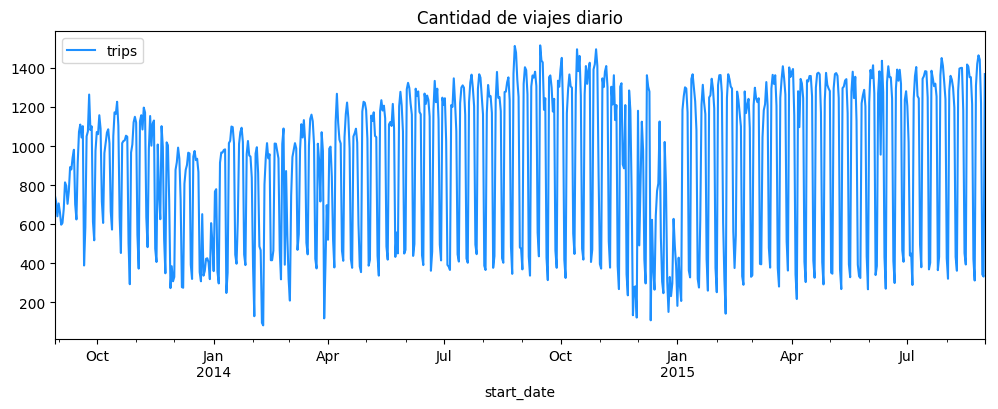

In [9]:
trips.assign(trips=1).groupby(by='start_date').sum().reset_index().plot(x='start_date',y='trips',title='Cantidad de viajes diario',color='dodgerblue')

### Aqui es clara que la cantidad de viajes disminuye cuando esta en la epoca invernal


# ¿Cual es la cantidad promedio de viajes en un dia de semana?

In [10]:
tripsByDay = trips[trips['duration'] < 7200 ]

In [11]:
tripsByDay = tripsByDay.assign(trips=1).groupby(by=['start_date','numberdayofweek','dayofweek']).sum().reset_index()

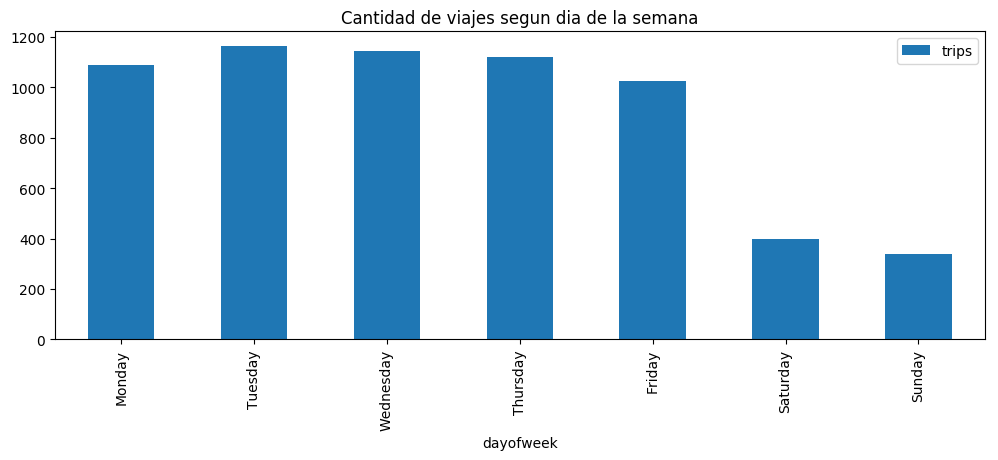

In [12]:
tripsByDay.groupby(by=['dayofweek','numberdayofweek']).mean().reset_index()\
    .sort_values('numberdayofweek')\
    .plot(kind='bar',x='dayofweek',y='trips',title='Cantidad de viajes segun dia de la semana')

In [13]:
tripsByDay = trips[trips['duration'] < 3000] 
tripsByDay['numberdayofweek'] = tripsByDay['numberdayofweek']\
        .apply(lambda x : int(x) + np.random.uniform(-0.4,0.4))
    

/home/brahvic/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


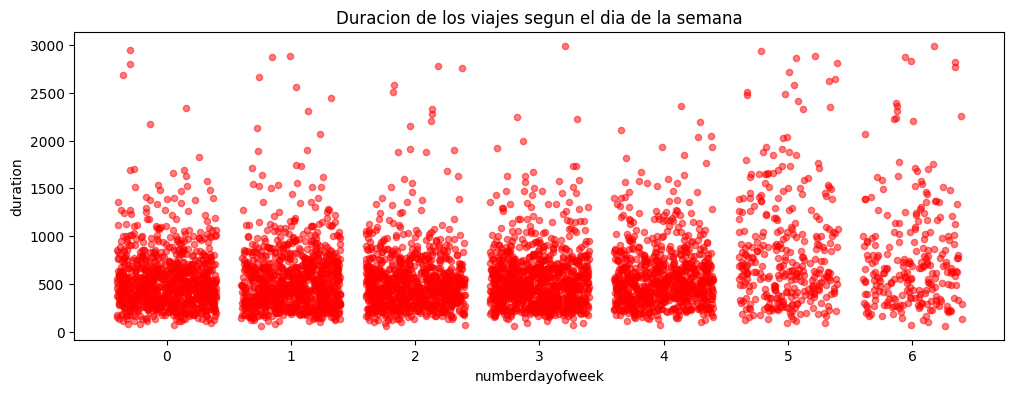

In [14]:
tripsByDay.sample(5000).plot(kind='scatter',x='numberdayofweek',y='duration',alpha=0.5,title='Duracion de los viajes segun el dia de la semana',color='red')

# ¿Cual es el promedio de duracion de un viaje, en los viajes que duran menos de 5000 segundos?

In [15]:
durationTrips = trips[trips['duration'] < 5000]

In [16]:
durationTripsByDay = durationTrips.assign(trips=1).groupby(by=['numberdayofweek','dayofweek']).mean().reset_index()

In [17]:
durationTripsByDay

,numberdayofweek,dayofweek,id,duration,start_station_id,end_station_id,bike_id,trips
0,0,Monday,472543.918562,576.359459,58.247304,58.267157,428.490030,1.0
1,1,Tuesday,468700.364038,566.061758,58.234662,58.216284,427.879461,1.0
2,2,Wednesday,469925.408844,573.062138,58.322230,58.300607,427.979608,1.0
3,3,Thursday,465456.827837,584.380291,58.097550,57.987228,428.099425,1.0
4,4,Friday,461617.989849,607.229523,58.088114,58.030368,428.209268,1.0
5,5,Saturday,419411.006777,922.248147,56.350508,56.244648,428.576245,1.0
6,6,Sunday,409282.584603,954.137773,55.575020,55.713688,423.136214,1.0


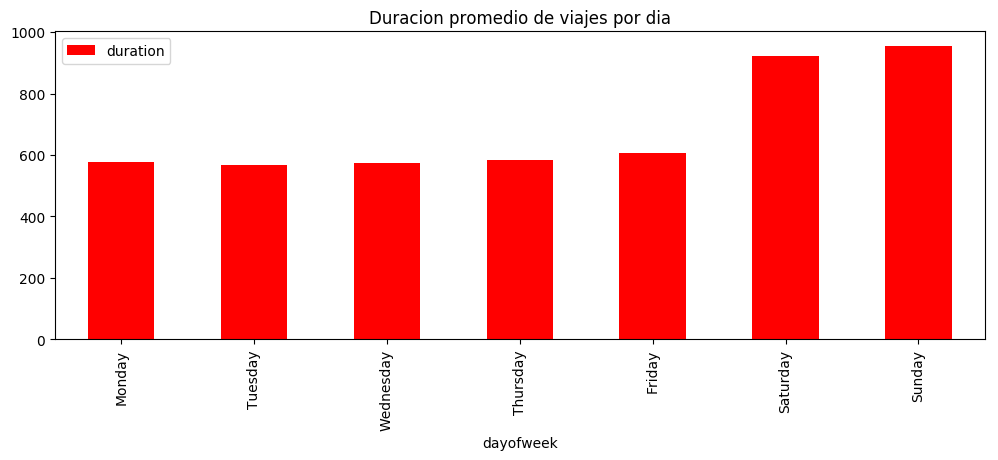

In [18]:
durationTripsByDay.plot(kind='bar',x='dayofweek',y='duration',color='red',title='Duracion promedio de viajes por dia')

### La duracion de los viajes los fines de semanas es mucho mayor.

# ¿Como se ve afectada la cantidad de viajes en los dias festivos?

In [19]:
holidayTrips = trips[trips['duration'] < 5000 ]

In [20]:

cal = calendarUSFH()
holidays = cal.holidays(return_name=True,start=pd.to_datetime('20140101'), end=pd.to_datetime('20141231'))
holidayDF = pd.DataFrame(holidays,columns=['festiveDay']).reset_index()

In [21]:
holidayDF.rename(columns={'index':'start_date'},inplace=True)

In [22]:
tripsInHolidays = holidayTrips[(holidayTrips['start_date'].isin(holidays.keys()) ) | (holidayTrips['end_date'].isin(holidays.keys()))]
tripsInHolidays = pd.merge(holidayDF, tripsInHolidays, on='start_date', how='left')

In [23]:
tripsInHolidays.shape

(5101, 14)

In [24]:

tripsInHolidays['dayofweek'] = tripsInHolidays['start_date'].apply(lambda x : calendar.day_name[x.dayofweek])

In [25]:
tripsInHolidays.sample()

,start_date,festiveDay,id,duration,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,numberdayofweek,dayofweek
439,2014-01-20,Dr. Martin Luther King Jr.,159215,1541,Harry Bridges Plaza (Ferry Building),50,2014-01-20,2nd at Townsend,61,592,Subscriber,94904,0,Monday


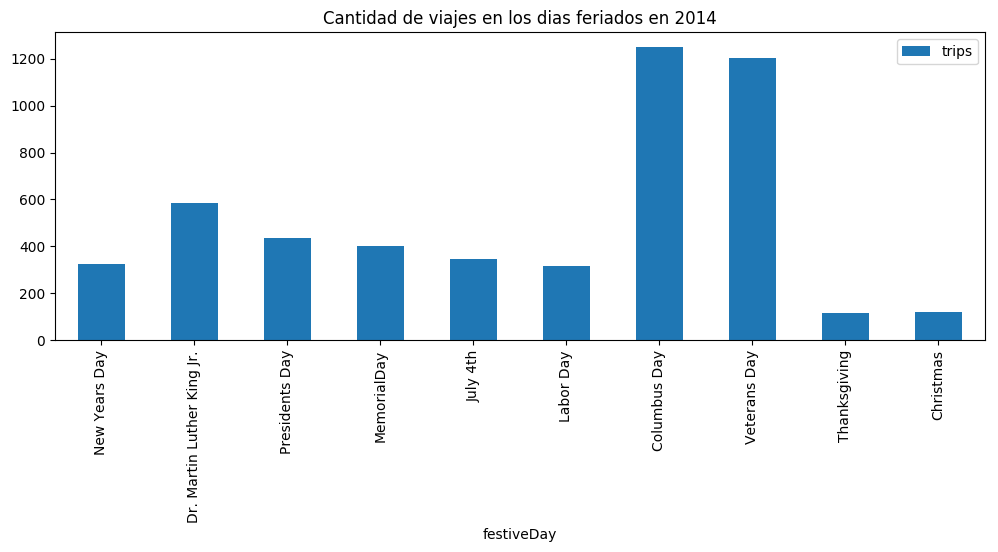

In [26]:
tripsInHolidays.assign(trips=1).groupby(by=['festiveDay','start_date','dayofweek']).sum().reset_index()\
        .sort_values(by='start_date').reset_index()\
        .plot(kind='bar',x='festiveDay',y='trips',title='Cantidad de viajes en los dias feriados en 2014')

### Aqui se pude ver como los viajes en los dias festivos normalmente se encuentran en valores normales para lo que seria un sabado o un domingo, a excepcion de 'Columbus Day' y 'Veretans Day'

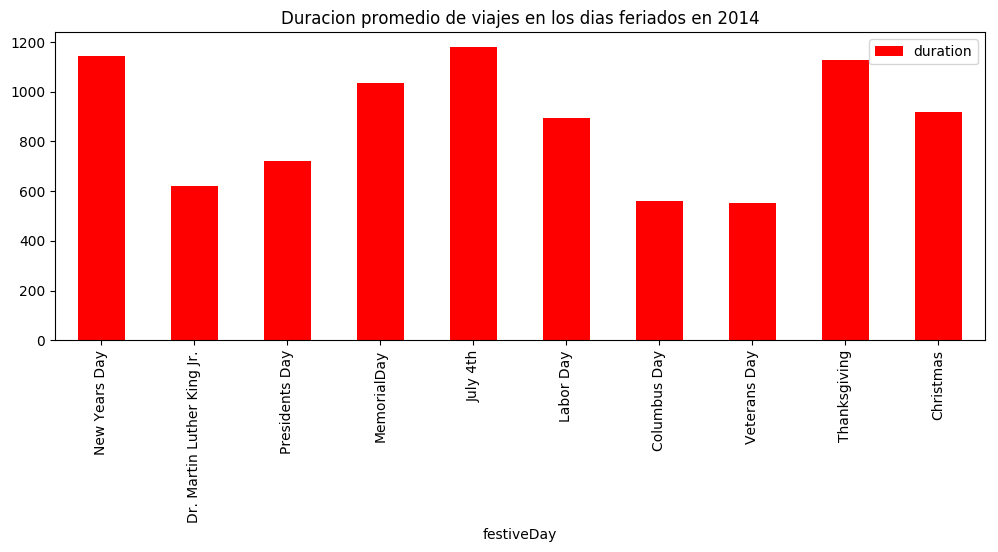

In [27]:
tripsInHolidays.assign(trips=1).groupby(by=['festiveDay','start_date','dayofweek']).mean().reset_index()\
        .sort_values(by='start_date').reset_index()\
        .plot(kind='bar',x='festiveDay',y='duration',title='Duracion promedio de viajes en los dias feriados en 2014',color='red')

### La duracion por su parte, en la mayoria tienen una cantidad similar a los fines de semanas, a exception de 'Columbus Day', 'Veretans Day' y 'Dr. Martin Luther King Jr.'

In [28]:
holidaysFullData = cal.holidays(return_name=True,start=trips.start_date.min(), end=trips.start_date.max())
holidaysFullDataDF = pd.DataFrame(holidaysFullData,columns=['festiveDay']).reset_index()

In [29]:
holidaysFullDataDF.rename(columns={'index':'start_date'},inplace=True)

In [30]:
tripsInHolidaysFullData = holidayTrips[(holidayTrips['start_date'].isin(holidaysFullData.keys()) ) | (holidayTrips['end_date'].isin(holidaysFullData.keys()))]
tripsInHolidaysFullData = pd.merge(holidaysFullDataDF, tripsInHolidaysFullData, on='start_date', how='left')

In [31]:

tripsInHolidaysFullData.shape

(10196, 14)

In [32]:
tripsInHolidaysFullData['dayofweek'] = tripsInHolidaysFullData['start_date']\
    .apply(lambda x : calendar.day_name[x.dayofweek])

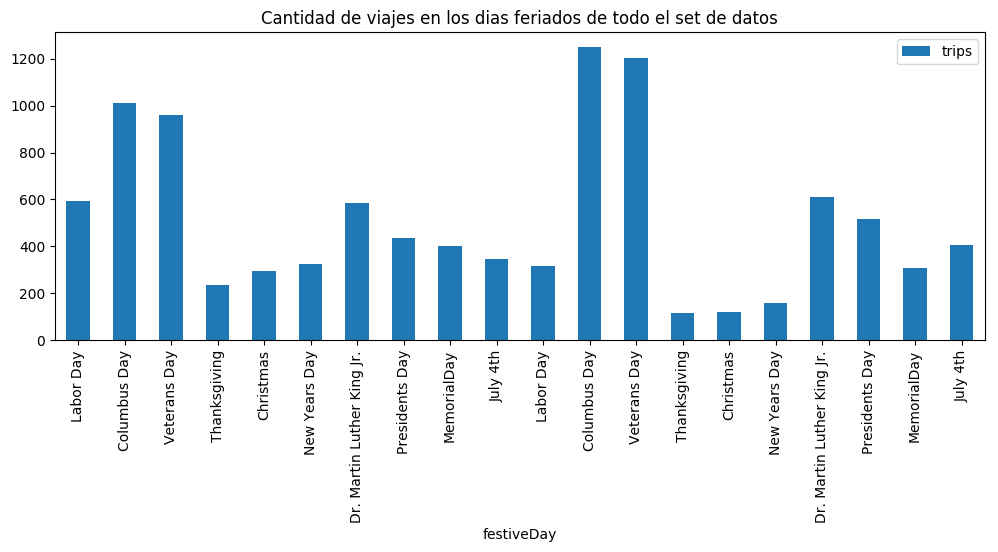

In [33]:
tripsInHolidaysFullData.assign(trips=1).groupby(by=['festiveDay','start_date','dayofweek']).sum().reset_index()\
        .sort_values(by='start_date').reset_index()\
        .plot(kind='bar',x='festiveDay',y='trips',title='Cantidad de viajes en los dias feriados de todo el set de datos')

### En el caso de tomar los dias feriados de todo el set de datos, nos encontramos ante la misma situacion que los dias festivos de 2014

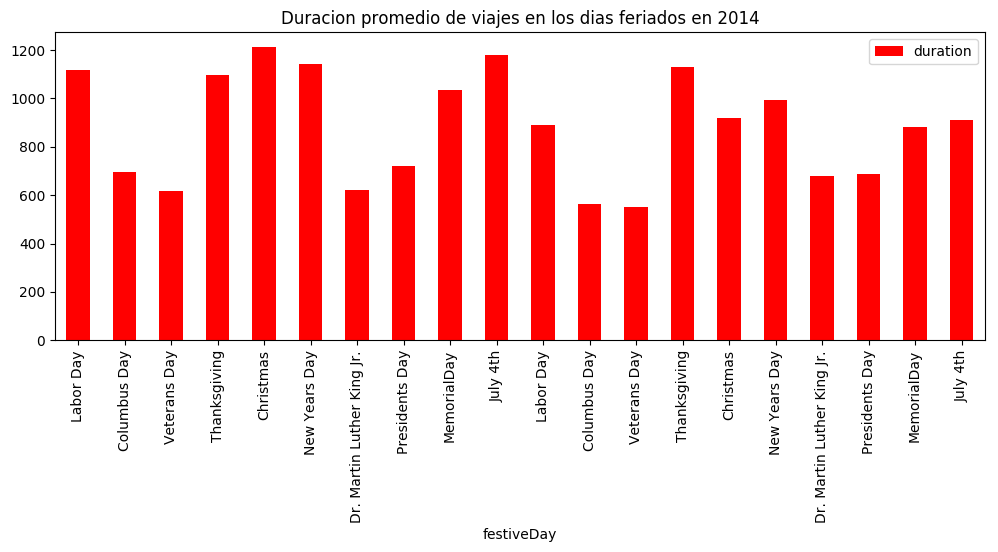

In [34]:
tripsInHolidaysFullData.assign(trips=1).groupby(by=['festiveDay','start_date','dayofweek']).mean().reset_index()\
        .sort_values(by='start_date').reset_index()\
        .plot(kind='bar',x='festiveDay',y='duration',title='Duracion promedio de viajes en los dias feriados en 2014',color='red')

# ¿Como afecta el clima  a la cantidad de viajes que hay por dia?

In [4]:
weather = pd.read_csv('data/weather.csv',dtype={'zip_code': str})

In [5]:
trips = pd.read_csv('data/trip.csv')

In [6]:
def splitDate(date):
    lineSplit = date.split('/')
    return str(lineSplit[2]) +\
        str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + \
        str(lineSplit[1] if int(lineSplit[1]) >= 10 else '0' + str(lineSplit[1]) )

#### Tranformamos las fechas en un formato que sea mas facil de manejar

In [7]:
weather['date'] = weather['date'].apply(lambda x : pd.to_datetime(splitDate(x)))

In [8]:
trips['start_date'] = trips['start_date'].apply(lambda x : pd.to_datetime(splitDate(x.split(' ')[0])) )

In [9]:
weather['precipitation_inches'] = weather['precipitation_inches'].apply(lambda x : 0.005 if (x == 'T') else float(x))

weather = weather[weather.precipitation_inches.isnull() == False]

weather = weather.fillna(0)

weather['events'] = weather['events'].apply(lambda x : 'Normal' if x == 0 else x)
weather['events'] = weather['events'].apply(lambda x : 'Rain' if x == 'rain' else x)

#### Vamos a hacer un Join en el cual vamos a tener la duracion promedio de los viajes en un determinado dia, y ademas la cantidad de viajes en un dia

In [10]:
tripsWithReduceDuration = trips[(trips['duration'] < 7200) & (trips['duration'] > 60)]

In [11]:
tripsByDay = tripsWithReduceDuration[['start_date']]
tripsByDay.rename(columns={'start_date' : 'date'},inplace=True)

/home/pabloernesto/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [12]:
tripsByDay = tripsByDay.assign(tripsByDay = 1).groupby(by='date').sum()
tripsByDay = tripsByDay.reset_index()

In [13]:
durationTripsByDay = tripsWithReduceDuration[['start_date','duration']]
durationTripsByDay.rename(columns={'start_date' : 'date','duration' : 'meanDurationByDay'},inplace=True)

In [14]:
durationTripsByDay = durationTripsByDay.groupby(by='date').mean().reset_index()

In [15]:
durationTripsByDay.sample(5)

,date,meanDurationByDay
611,2015-05-02,915.489097
454,2014-11-26,539.896414
691,2015-07-21,607.580766
86,2013-11-23,1191.590818
655,2015-06-15,580.474640


In [16]:
durationAndTripsByDay = pd.merge(tripsByDay,durationTripsByDay, on='date',how='left')
durationAndTripsByDay.sample()
durationAndTripsByDay['numberdayofweek'] = durationAndTripsByDay['date'].apply(lambda x : x.dayofweek)
durationAndTripsByDay['dayofweek'] = durationAndTripsByDay['date'].apply(lambda x : calendar.day_name[x.dayofweek])

In [17]:
dataMerge = pd.merge(durationAndTripsByDay, weather, on='date', how='left')
dataMerge.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
1119,2014-04-09,1111,613.656166,2,Wednesday,75.0,65.0,54.0,55.0,52.0,...,10.0,9.0,13.0,5.0,18.0,0.0,4.0,Normal,297.0,95113


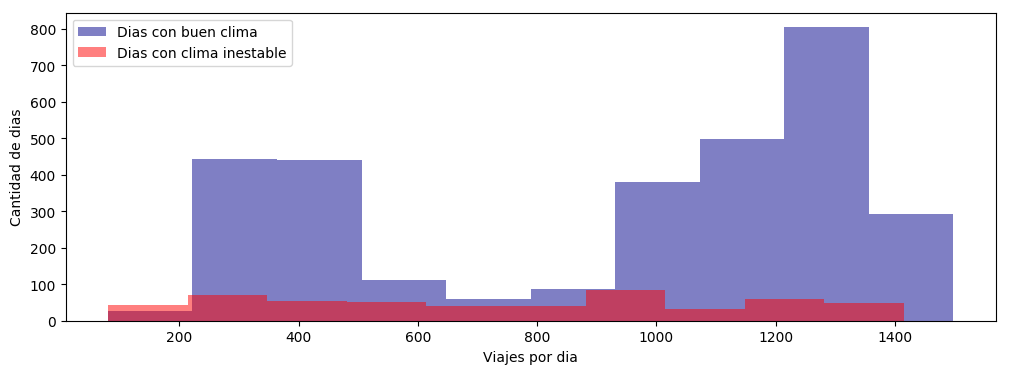

In [49]:
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['tripsByDay'],color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['tripsByDay'],color='red',alpha=0.5)
plt.xlabel('Viajes por dia')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

Se ve como hay una marcada diferencia, eso puede ser producto de que la muestra de los viajes con clima estable es mucho mayor a la de los dias inestable. Vamos a corregir esto usando una miestra igual.

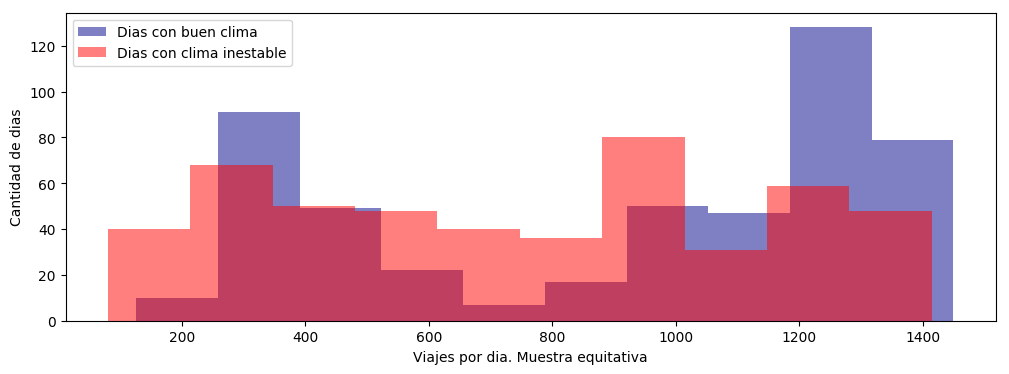

In [50]:
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['tripsByDay'].sample(500),color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['tripsByDay'].sample(500),color='red',alpha=0.5)
plt.xlabel('Viajes por dia. Muestra equitativa')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

Como ya sabemos del caso anterior, aqui va a haber un conflicto determinado por la muestra.

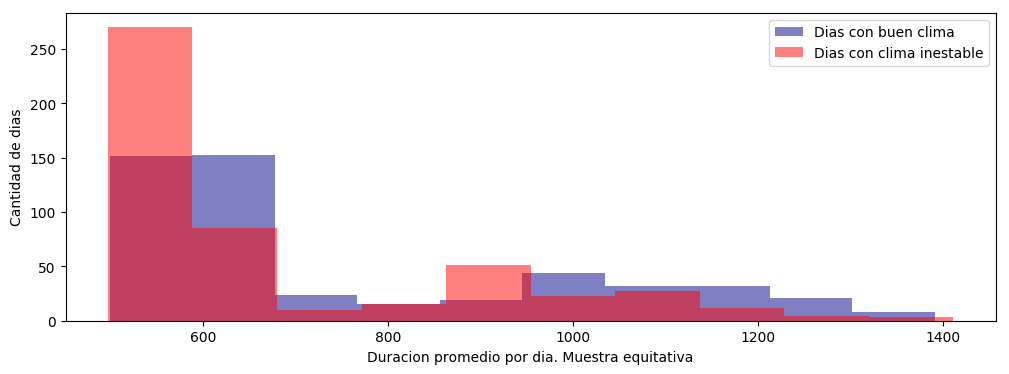

In [51]:
# histtype : {'bar', 'barstacked', 'step',  'stepfilled'}, optional
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['meanDurationByDay'].sample(500),color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['meanDurationByDay'].sample(500),color='red',alpha=0.5)
plt.xlabel('Duracion promedio por dia. Muestra equitativa')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

In [52]:
plt.rcParams['figure.figsize'] = (15, 5)

durationAndTripsByWeekDay = pd.merge(durationAndTripsByDay, weather, on='date', how='left')

In [53]:
correlationData = pd.merge(durationAndTripsByDay, weather, on='date', how='left')
correlationData.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
2514,2015-01-13,1361,549.20867,1,Tuesday,65.0,54.0,43.0,48.0,43.0,...,5.0,0.0,16.0,4.0,20.0,0.0,3.0,Fog,203.0,95113


In [54]:
# Relationship between columns
correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',\
                 'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',\
                 'cloud_cover']].corr().abs()

,tripsByDay,meanDurationByDay,numberdayofweek,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover
tripsByDay,1.000000,0.797500,0.684064,0.233733,0.141996,0.051457,0.097514,0.064926,0.041974,0.041209,0.131320,0.061177
meanDurationByDay,0.797500,1.000000,0.712849,0.093335,0.056387,0.016870,0.024100,0.052761,0.016134,0.010779,0.068889,0.113279
numberdayofweek,0.684064,0.712849,1.000000,0.001263,0.018123,0.032006,0.028222,0.013868,0.018682,0.006067,0.003466,0.001630
mean_temperature_f,0.233733,0.093335,0.001263,1.000000,0.617477,0.068019,0.509276,0.187408,0.274603,0.015293,0.070142,0.035683
mean_dew_point_f,0.141996,0.056387,0.018123,0.617477,1.000000,0.677437,0.405035,0.091269,0.233726,0.064003,0.051778,0.215646
mean_humidity,0.051457,0.016870,0.032006,0.068019,0.677437,1.000000,0.060757,0.145302,0.011083,0.032615,0.145442,0.376591
mean_sea_level_pressure_inches,0.097514,0.024100,0.028222,0.509276,0.405035,0.060757,1.000000,0.093653,0.391993,0.155546,0.176203,0.162971
mean_visibility_miles,0.064926,0.052761,0.013868,0.187408,0.091269,0.145302,0.093653,1.000000,0.173664,0.072271,0.181641,0.166172
mean_wind_speed_mph,0.041974,0.016134,0.018682,0.274603,0.233726,0.011083,0.391993,0.173664,1.000000,0.337248,0.132158,0.326831
max_gust_speed_mph,0.041209,0.010779,0.006067,0.015293,0.064003,0.032615,0.155546,0.072271,0.337248,1.000000,0.158793,0.117317


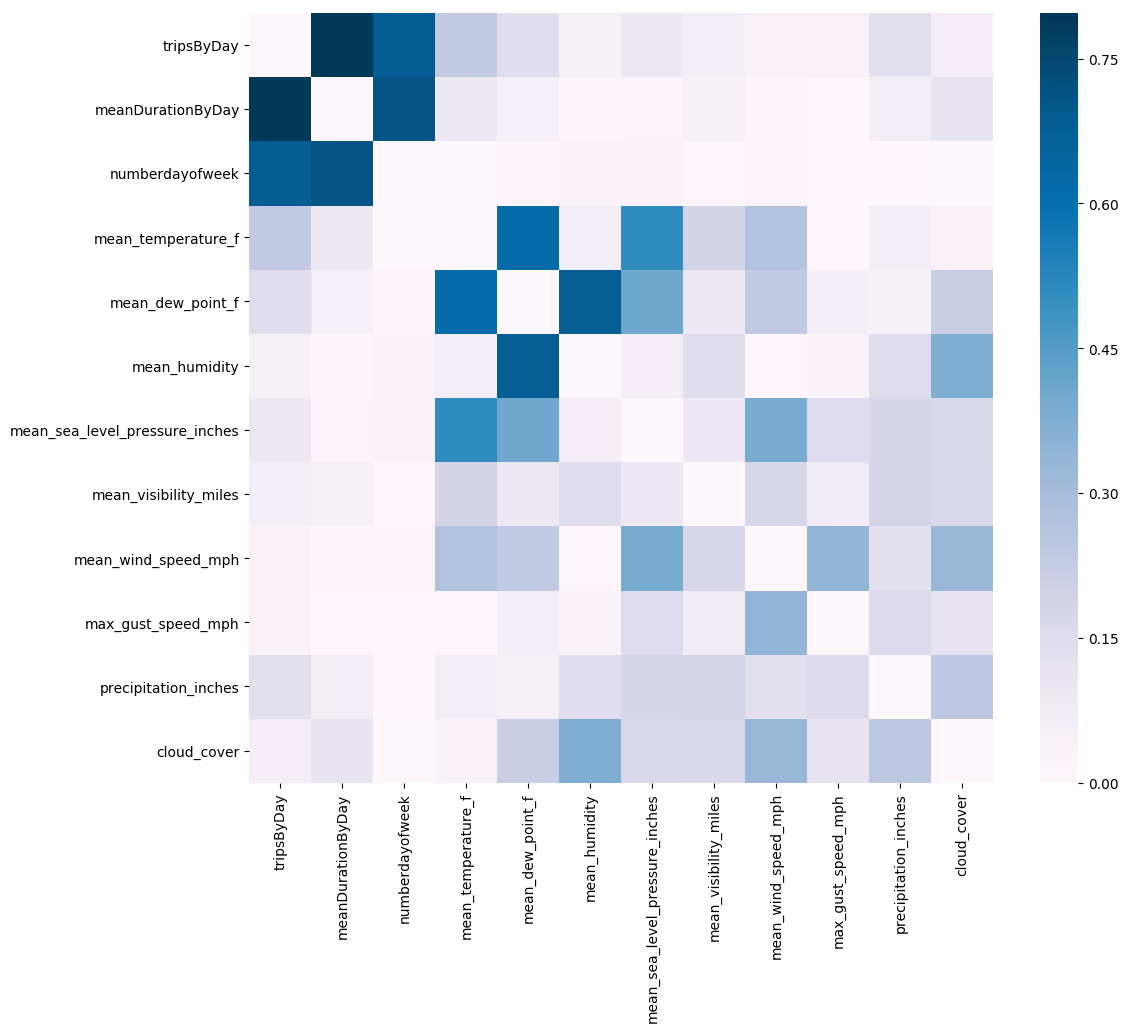

In [57]:
#'mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',
#'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches','cloud_cover'

fig, ax = plt.subplots(figsize=(12,10));        # Sample figsize in inches
cor = correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',\
                 'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',\
                 'cloud_cover']].corr().abs()
cor.values[[np.arange(12)]*2] = 0
sns.heatmap(cor,cmap='PuBu');

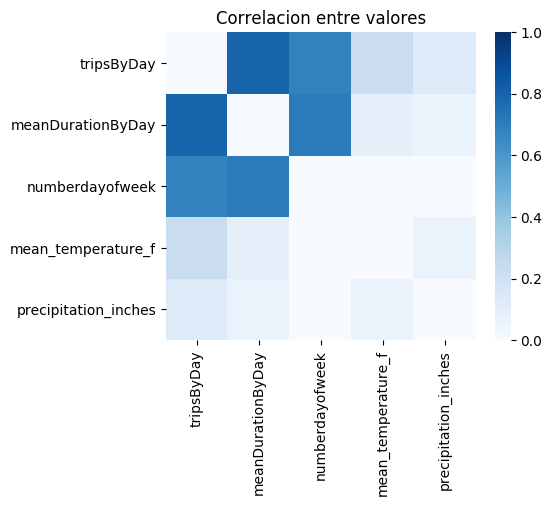

In [58]:
fig, ax = plt.subplots(figsize=(5,4));        # Sample figsize in inches
cor = correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'precipitation_inches']]\
        .corr().abs()

    
ax = plt.axes()
ax.set_title('Correlacion entre valores')
cor.values[[np.arange(5)]*2] = 0
sns.heatmap(cor,cmap='Blues',vmin=0, vmax=1,ax=ax)


In [59]:
durationAndTripsByDay.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek
234,2014-04-20,330,1151.921212,6,Sunday


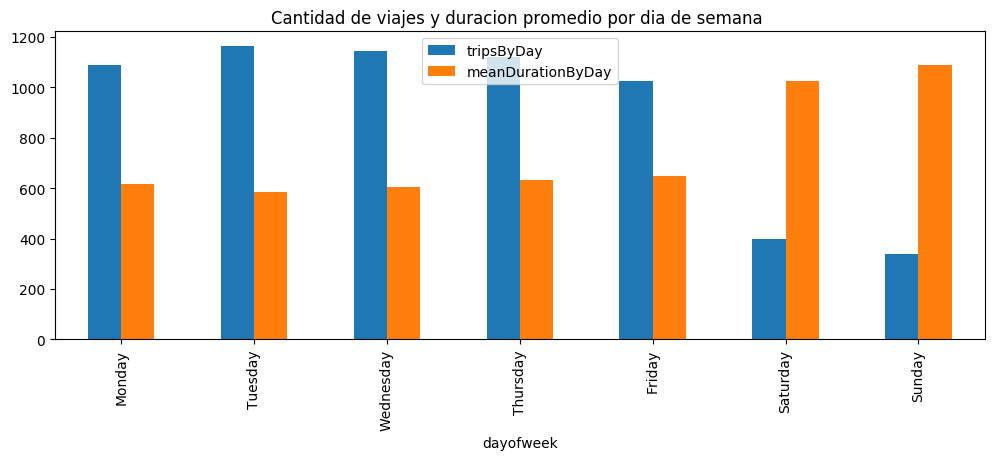

In [60]:
dataMergeByDay = durationAndTripsByDay.groupby(by=['numberdayofweek','dayofweek']).mean().reset_index()
dataMergeByDay.plot(kind='bar',x='dayofweek',y=['tripsByDay','meanDurationByDay'],title='Cantidad de viajes y duracion promedio por dia de semana ')

In [61]:
tripsMean = pd.merge(durationAndTripsByDay, weather, on='date', how='left')

In [62]:
meanValueOfMeanTF = tripsMean.mean_temperature_f.mean()

In [63]:
tripsMean['mean_temperature_f'] = tripsMean['mean_temperature_f'].apply(lambda x : float(x)/float(meanValueOfMeanTF) )

In [64]:
tripsMean.tripsByDay.mean()

896.95332969432309

In [65]:
meanValueOfTBD = tripsMean.tripsByDay.mean()
tripsMean['tripsByDay'] = tripsMean['tripsByDay'].apply(lambda x : float(x)/float(meanValueOfTBD) )
tripsMean.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
2123,2014-10-27,1.548576,566.116631,0,Monday,70.0,0.962502,48.0,53.0,48.0,...,10.0,10.0,14.0,3.0,17.0,0.0,0.0,Normal,330.0,94041


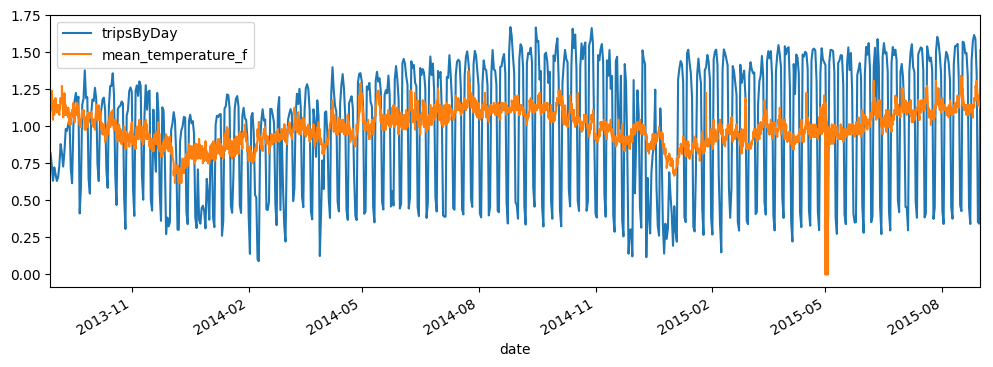

In [66]:
tripsMean.plot(x='date',y=['tripsByDay','mean_temperature_f'])

In [67]:
dataMerge[ dataMerge['mean_temperature_f'] < 0.50 ]

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
3053,2015-05-01,1267,638.468035,4,Friday,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,16.0,6.0,22.0,0.0,0.0,Normal,340.0,94041
3058,2015-05-02,321,915.489097,5,Saturday,0.0,0.0,0.0,0.0,0.0,...,10.0,9.0,14.0,7.0,18.0,0.0,3.0,Normal,356.0,94041
3063,2015-05-03,323,1113.860681,6,Sunday,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,17.0,7.0,0.0,0.0,2.0,Normal,23.0,94041


In [68]:
weather[weather['date'] == pd.to_datetime('20150501')]

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
2082,2015-05-01,76.0,65.0,53.0,54.0,51.0,48.0,93.0,71.0,49.0,...,10.0,9.0,20.0,9.0,23.0,0.0,2.0,Normal,312.0,94107
2447,2015-05-01,78.0,68.0,57.0,55.0,48.0,43.0,82.0,55.0,34.0,...,10.0,10.0,13.0,3.0,16.0,0.0,0.0,Normal,329.0,94063
2812,2015-05-01,77.0,67.0,57.0,61.0,57.0,50.0,88.0,68.0,50.0,...,10.0,10.0,21.0,9.0,0.0,0.0,0.0,Normal,347.0,94301
3177,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,16.0,6.0,22.0,0.0,0.0,Normal,340.0,94041
3542,2015-05-01,84.0,71.0,57.0,53.0,48.0,41.0,86.0,56.0,25.0,...,10.0,10.0,18.0,7.0,22.0,0.0,1.0,Normal,251.0,95113


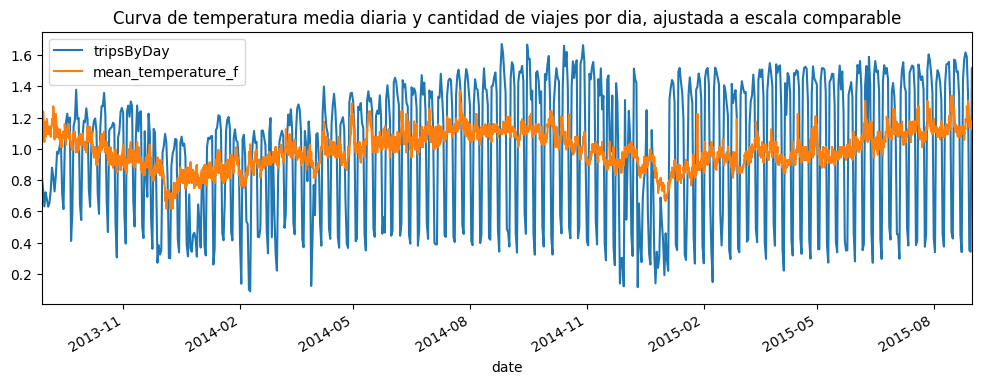

In [69]:
tripsMean[tripsMean['mean_temperature_f'] > 0].plot(x='date',y=['tripsByDay','mean_temperature_f'],title='Curva de temperatura media diaria y cantidad de viajes por dia, ajustada a escala comparable')

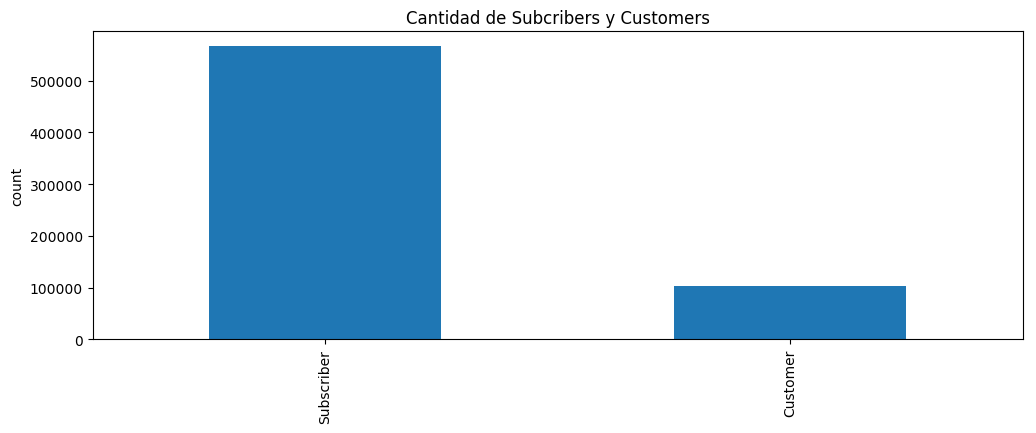

In [6]:
trip['subscription_type'].value_counts().plot.bar(title = "Cantidad de Subcribers y Customers")
plt.ylabel('count')
   

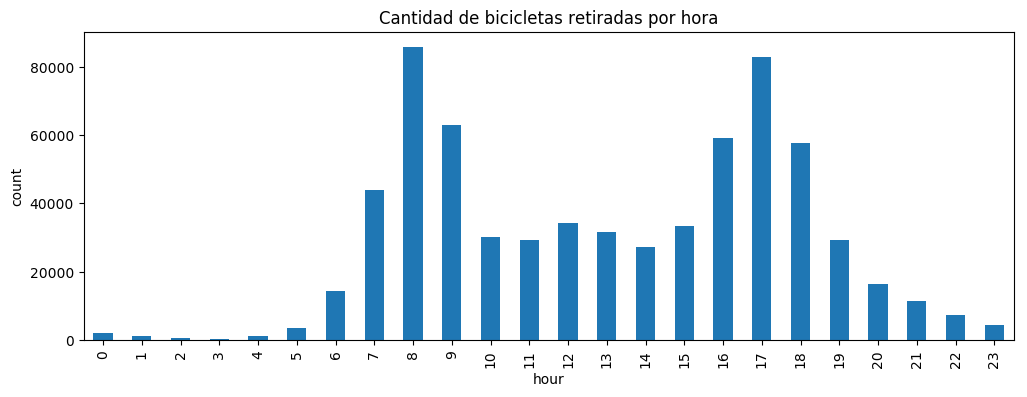

In [8]:
date = trip.loc[:,'start_date'].str.split(' ')
trip['date'] = date.map(lambda date: date[0])
trip['hour'] = date.map(lambda hour: hour[1])
trip['hour'] = trip.loc[:,'hour'].str.split(':').map(lambda h: h[0])


# Cantidad de bicicletas retiradas por hora
trip.sort_values(by=('hour'), ascending=True)['hour']\
    .map(lambda x :int(x)).value_counts().sort_index().plot.bar(title="Cantidad de bicicletas retiradas por hora")
plt.ylabel('count')
plt.xlabel('hour')

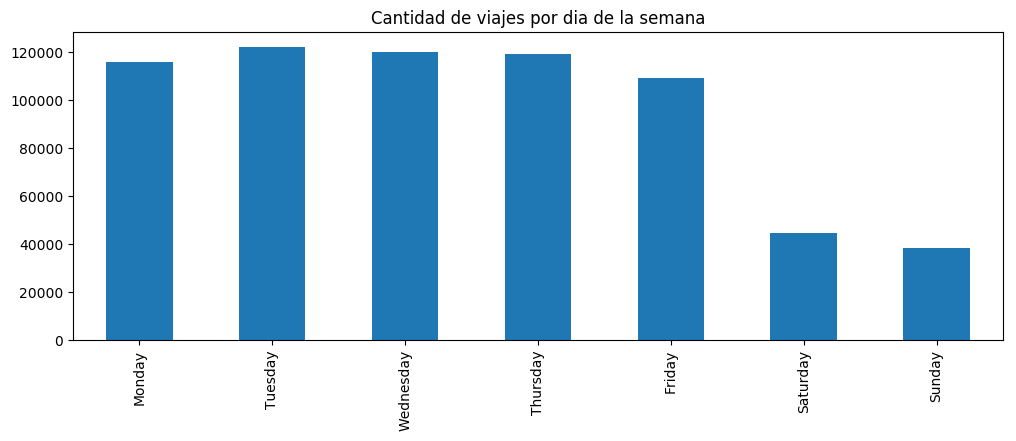

In [9]:
# Cantidad de bicicletas por dia de la semana filtrado por zona horaria de [5am..19pm]

tmp = trip.loc[(trip.hour > 4) & (trip.hour < 20)]
tmp['start_date'] = pd.to_datetime(trip['start_date'])
tmp['weekday'] = tmp['start_date'].dt.dayofweek
tmp['weekday'].value_counts().sort_index().rename(lambda x: calendar.day_name[x])\
                .plot.bar(title = "Cantidad de viajes por dia de la semana")

                

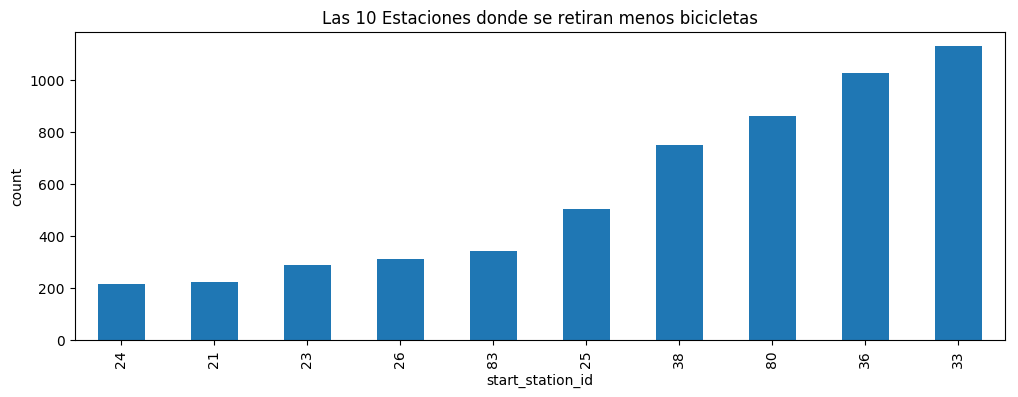

In [10]:
# 10 Estaciones donde se retiran menos bicicletas
trip.start_station_id.value_counts().sort_values(ascending = True)\
    .nsmallest(10).plot.bar(title = "Las 10 Estaciones donde se retiran menos bicicletas")
plt.ylabel('count')
plt.xlabel('start_station_id')
    

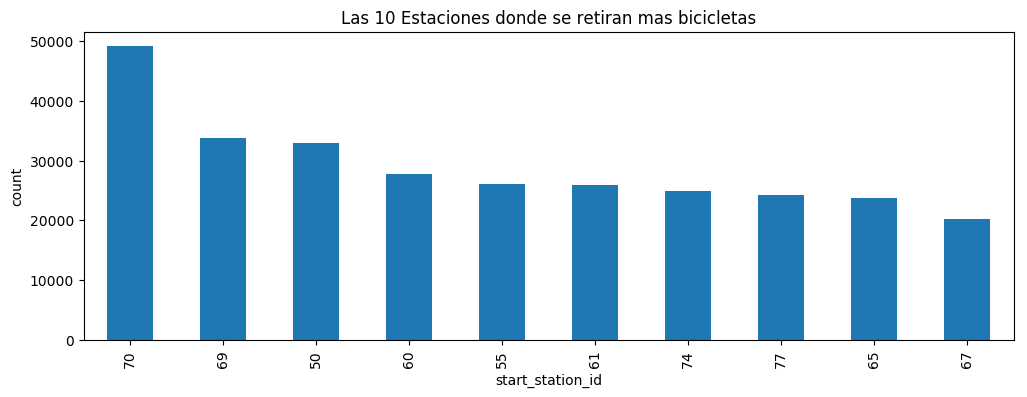

In [11]:
# 10 Estaciones donde se retiran mas bicicletas
trip.start_station_id.value_counts().sort_values(ascending = False)\
    .nlargest(10).plot.bar(title = "Las 10 Estaciones donde se retiran mas bicicletas")
plt.ylabel('count')
plt.xlabel('start_station_id')

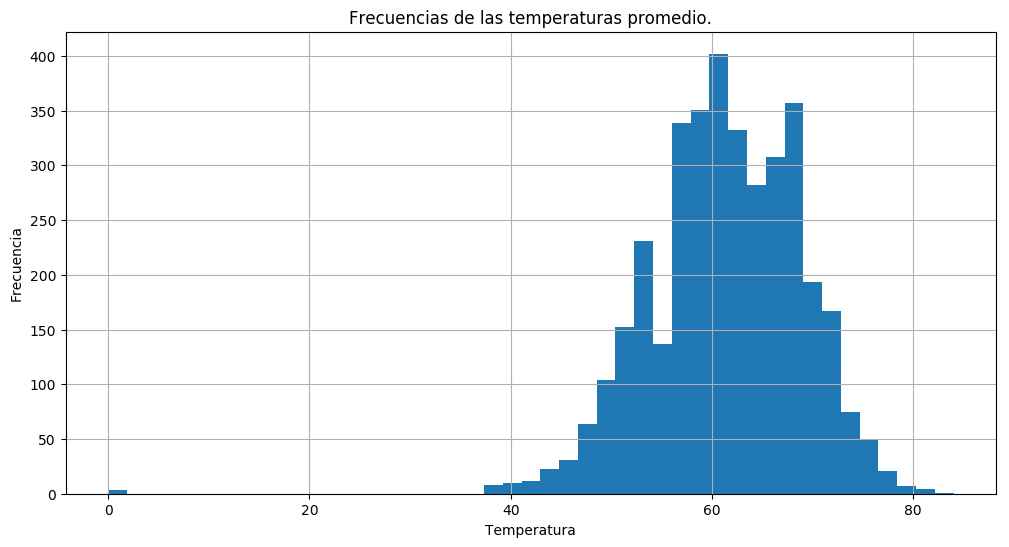

In [20]:
weather.mean_temperature_f.hist(bins = 45, figsize = (12,6))
plt.title("Frecuencias de las temperaturas promedio.")
plt.xlabel("Temperatura")
plt.ylabel("Frecuencia")

In [ ]:
# San francisco duration[mean,size]
# Filtramos por rango de horario[5hs..20hs] , por durarion[0secs..7200secs] y Subcribers
# IMPORTANTE: plots hechos en R, link: https://github.com/pabloernesto/sfBikes/blob/master/plots_en_R.ipynb
station_in_san_francisco = station.loc[(station.city == 'San Francisco')]
station_in_san_francisco = station_in_san_francisco.loc[:,('id', 'name', 'lat','long')]
trip_station_in_san_francisco =  pd.merge(trip, station_in_san_francisco, how='inner',  left_on='start_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
trip_station_in_san_francisco = pd.merge(trip_station_in_san_francisco, station_in_san_francisco, how='inner',  left_on='end_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

trip_station_in_san_francisco = trip_station_in_san_francisco.loc[:,('id_x','duration', 'start_date', 'start_station_name','start_station_id', 'end_date', \
                        'end_station_name','end_station_id', 'lat_x', 'long_x', 'lat_y', 'long_y', 'subscription_type')\
                                                                   ]

date = trip_station_in_san_francisco.loc[:,'start_date'].str.split(' ')
trip_station_in_san_francisco['date'] = date.map(lambda date: date[0])
trip_station_in_san_francisco['hour'] = date.map(lambda hour: hour[1])
trip_station_in_san_francisco['hour'] = trip_station_in_san_francisco.loc[:,'hour'].str.split(':').map(lambda h: h[0])

#filtro
trip_station_in_san_francisco['hour'] = trip_station_in_san_francisco['hour'].map(lambda x : int(x))
trip_station_in_san_francisco = trip_station_in_san_francisco.loc[(trip_station_in_san_francisco.hour >= 5)&\
                                   (trip_station_in_san_francisco.hour <= 20)&\
                                  (trip_station_in_san_francisco.duration < 7200)]

trip_station_in_san_francisco = trip_station_in_san_francisco.rename(columns={'id_x': 'id', 'hour':'start_hour'})
trip_station_in_san_francisco.loc[(trip_station_in_san_francisco.subscription_type == 'Subscriber')]\
    .groupby(['long_x','lat_x', 'long_y', 'lat_y'])['duration'].agg([np.mean, np.size])\
                    .to_csv("../data/trip_station_in_sf_duration_mean_size_subcribers.csv")

In [ ]:
# San Redwood Mountain Palo Alto duration[mean,size]
# Filtramos por rango de horario[8hs..19hs], por durarion[0secs..7200secs] y Subcribers
# IMPORTANTE: plots hechos en R, link: https://github.com/pabloernesto/sfBikes/blob/master/plots_en_R.ipynb
station_in_rc_mv_pa = station.loc[(station.city == 'Redwood City') |\
                                      (station.city == 'Mountain View') |\
                                      (station.city == 'Palo Alto')]
station_in_rc_mv_pa = station_in_rc_mv_pa.loc[:,('id', 'name', 'lat','long')]
trip_station_in_rc_mv_pa =  pd.merge(trip, station_in_rc_mv_pa, how='inner',  left_on='start_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
trip_station_in_rc_mv_pa = pd.merge(trip_station_in_rc_mv_pa, station_in_rc_mv_pa, how='inner',  left_on='end_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

trip_station_in_rc_mv_pa = trip_station_in_rc_mv_pa.loc[:,('id_x','duration', 'start_date', 'start_station_name','start_station_id', 'end_date', \
                        'end_station_name','end_station_id', 'lat_x', 'long_x', 'lat_y', 'long_y', 'subscription_type')\
                                                                   ]

date = trip_station_in_rc_mv_pa.loc[:,'start_date'].str.split(' ')
trip_station_in_rc_mv_pa['date'] = date.map(lambda date: date[0])
trip_station_in_rc_mv_pa['hour'] = date.map(lambda hour: hour[1])
trip_station_in_rc_mv_pa['hour'] = trip_station_in_rc_mv_pa.loc[:,'hour'].str.split(':').map(lambda h: h[0])

#filtro
trip_station_in_rc_mv_pa['hour'] = trip_station_in_rc_mv_pa['hour'].map(lambda x : int(x))
trip_station_in_rc_mv_pa = trip_station_in_rc_mv_pa.loc[(trip_station_in_rc_mv_pa.hour >= 7)&\
                                   (trip_station_in_rc_mv_pa.hour <= 20)&\
                                  (trip_station_in_rc_mv_pa.duration < 7200)]

trip_station_in_rc_mv_pa = trip_station_in_rc_mv_pa.rename(columns={'id_x': 'id', 'hour':'start_hour'})
trip_station_in_rc_mv_pa.loc[(trip_station_in_rc_mv_pa.subscription_type == 'Subscriber')]\
    .groupby(['long_x','lat_x', 'long_y', 'lat_y'])['duration'].agg([np.mean, np.size])\
                    .to_csv("../data/trip_station_in_rc_mv_pa_duration_mean_size_subcribers.csv")

In [ ]:
# San Jose duration[mean,size]
# Filtramos por rango de horario[8hs..19hs] , por durarion[0secs..7200secs] y Subcribers
# IMPORTANTE: plots hechos en R, link: https://github.com/pabloernesto/sfBikes/blob/master/plots_en_R.ipynb
station_in_san_jose = station.loc[(station.city == 'San Jose')]
station_in_san_jose = station_in_san_jose.loc[:,('id', 'name', 'lat','long')]
trip_station_in_san_jose =  pd.merge(trip, station_in_san_jose, how='inner',  left_on='start_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
trip_station_in_san_jose = pd.merge(trip_station_in_san_jose, station_in_san_jose, how='inner',  left_on='end_station_id', right_on='id', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

trip_station_in_san_jose = trip_station_in_san_jose.loc[:,('id_x','duration', 'start_date', 'start_station_name','start_station_id', 'end_date', \
                        'end_station_name','end_station_id', 'lat_x', 'long_x', 'lat_y', 'long_y', 'subscription_type')\
                                                                   ]

date = trip_station_in_san_jose.loc[:,'start_date'].str.split(' ')
trip_station_in_san_jose['date'] = date.map(lambda date: date[0])
trip_station_in_san_jose['hour'] = date.map(lambda hour: hour[1])
trip_station_in_san_jose['hour'] = trip_station_in_san_jose.loc[:,'hour'].str.split(':').map(lambda h: h[0])

#filtro
trip_station_in_san_jose['hour'] = trip_station_in_san_jose['hour'].map(lambda x : int(x))
trip_station_in_san_jose = trip_station_in_san_jose.loc[(trip_station_in_san_jose.hour >= 7)&\
                                   (trip_station_in_san_jose.hour <= 20)&\
                                  (trip_station_in_san_jose.duration < 7200)]

trip_station_in_san_jose = trip_station_in_san_jose.rename(columns={'id_x': 'id', 'hour':'start_hour'})
trip_station_in_san_jose.loc[(trip_station_in_san_jose.subscription_type == 'Subscriber')]\
    .groupby(['long_x','lat_x', 'long_y', 'lat_y'])['duration'].agg([np.mean, np.size])\
                    .to_csv("../data/trip_station_in_sj_duration_mean_size_subcribers.csv")